In [150]:
import sys
sys.path.insert(0, '/Users/livestorborg/Desktop/FYS-STK4155/project2/code')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.neural_network import NeuralNetwork
from src.activations import Sigmoid, Linear
from src.losses import MSE
from src.optimizers import GD, RMSprop, Adam
from src.training import train
from src.metrics import mse
from src.utils import runge, polynomial_features, scale_data, OLS_parameters, inverse_scale_y, find_best_eta
from src.plotting import plot_learning_curves

# Setup for OLS Regression

In [151]:
SEED = 42
np.random.seed(SEED)

N = 300
x = np.linspace(-1, 1, N)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, 0.3, N)

In [152]:
X_poly = polynomial_features(x, p=14, intercept=False)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_poly, y_noise, test_size=0.2, random_state=SEED
)
# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(X_train_poly, y_train)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_poly, y_test, X_mean, X_std, y_mean
)

theta_ols = OLS_parameters(X_train_s, y_train_s)
y_pred_ols = X_test_s @ theta_ols
ols_mse = mse(y_test_s.reshape(-1, 1), y_pred_ols.reshape(-1, 1))

print(f"OLS Test MSE: {ols_mse:.6f}")

OLS Test MSE: 0.064547


# Setup for FFNN

In [153]:
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1), 
    test_size=0.2, random_state=SEED
)

# Scale
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(X_train_raw, y_train_nn)
X_test_s, y_test_s, _, _, _ = scale_data(X_test_raw, y_test_nn, X_mean, X_std, y_mean)

y_test_real = inverse_scale_y(y_test_s, y_mean)

# Parameters for FFNN

In [154]:
# Experiment 1: one hidden layer and 50 hidden nodes
layer_sizes_1 = [50, 1]
activations_1 = [Sigmoid(), Linear()]


# Experiment 2: two hidden layers and 100 hidden nodes each
layer_sizes_2 = [100, 100, 1]
activations_2 = [Sigmoid(), Sigmoid(), Linear()]


EPOCHS = 500
BATCH_SIZE = 32
LOSS = MSE()
NETWORK_INPUT_SIZE = 1

ETA_VALS = np.logspace(-5, -1, 5)

# Full batch Gradient Descent

### Find best eta for GD

In [155]:
best_eta_gd_1, best_mse_gd_1, results_gd_1 = find_best_eta(
    layer_sizes=layer_sizes_1,
    activations=activations_1,
    X_train=X_train_s,
    y_train=y_train_s,
    X_test=X_test_s,
    y_test=y_test_s,
    y_mean=y_mean,
    optimizer_type='gd',
    eta_vals=ETA_VALS,
    seed=SEED
)

best_eta_gd_2, best_mse_gd_2, results_gd_2 = find_best_eta(
    layer_sizes=layer_sizes_2,
    activations=activations_2,
    X_train=X_train_s,
    y_train=y_train_s,
    X_test=X_test_s,
    y_test=y_test_s,
    y_mean=y_mean,
    optimizer_type='gd',
    eta_vals=ETA_VALS,
    seed=SEED
)

print(f"Experiment 1: Best η: {best_eta_gd_1:.6f}, Best Test MSE: {best_mse_gd_1:.6f}")
print(f"Experiment 2: Best η: {best_eta_gd_2:.6f}, Best Test MSE: {best_mse_gd_2:.6f}")

  η=0.000010: Train MSE=0.197029, Test MSE=0.158787
  η=0.000100: Train MSE=0.191824, Test MSE=0.153497
  η=0.001000: Train MSE=0.182751, Test MSE=0.144907
  η=0.010000: Train MSE=0.181475, Test MSE=0.143966
  η=0.100000: Train MSE=2.125635, Test MSE=2.087126
  η=0.000010: Train MSE=0.193804, Test MSE=0.156179
  η=0.000100: Train MSE=0.181950, Test MSE=0.144395
  η=0.001000: Train MSE=0.181873, Test MSE=0.144322
  η=0.010000: Train MSE=0.181152, Test MSE=0.143622
  η=0.100000: Train MSE=10.823214, Test MSE=10.781336
Experiment 1: Best η: 0.010000, Best Test MSE: 0.143966
Experiment 2: Best η: 0.010000, Best Test MSE: 0.143622


### Experiment 1: One hidden layer & 50 hidden nodes

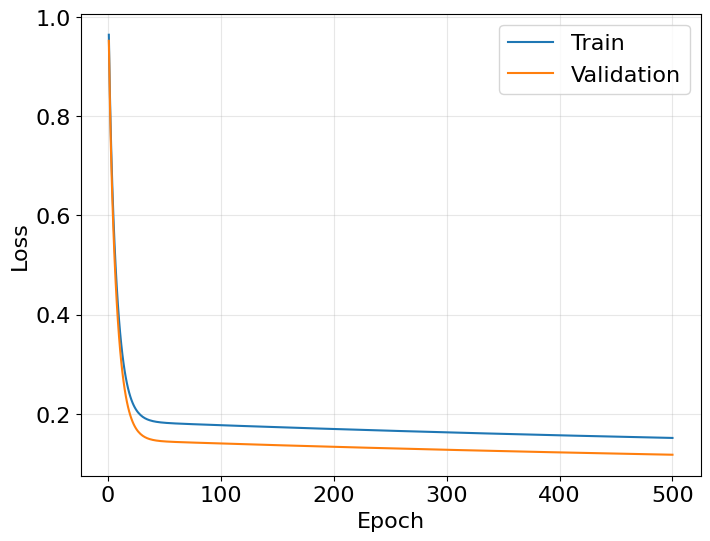

Final Train MSE (scaled): 0.151189
Final Test MSE (scaled): 0.117320
Final Test MSE (original scale): 0.117320


In [156]:
nn_gd_1 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_gd_1,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=GD(eta=best_eta_gd_1),
            epochs=EPOCHS,
            batch_size=len(X_train_s),  # Full batch
            stochastic=False,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_gd_1.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_gd_1.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

### Experiment 2: Two hidden layers & 100 hidden nodes

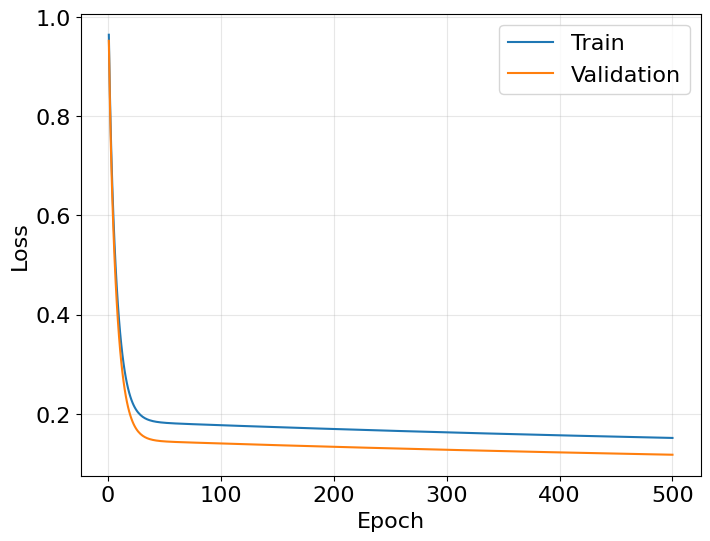

Final Train MSE (scaled): 0.151189
Final Test MSE (scaled): 0.117320
Final Test MSE (original scale): 0.117320


In [157]:
nn_gd_2 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_gd_2,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=GD(eta=best_eta_gd_2),
            epochs=EPOCHS,
            batch_size=len(X_train_s),  
            stochastic=False,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_gd_2.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_gd_2.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

# Stochastic Gradient Descent with RMSprop

### Find best eta for RMSprop

In [158]:
best_eta_rms_1, best_mse_rms_1, results_rms_1 = find_best_eta(
    layer_sizes=layer_sizes_1,
    activations=activations_1,
    X_train=X_train_s,
    y_train=y_train_s,
    X_test=X_test_s,
    y_test=y_test_s,
    y_mean=y_mean,
    optimizer_type='rmsprop',
    eta_vals=ETA_VALS,
    seed=SEED
)

best_eta_rms_2, best_mse_rms_2, results_rms_2 = find_best_eta(
    layer_sizes=layer_sizes_2,
    activations=activations_2,
    X_train=X_train_s,
    y_train=y_train_s,
    X_test=X_test_s,
    y_test=y_test_s,
    y_mean=y_mean,
    optimizer_type='rmsprop',
    eta_vals=ETA_VALS,
    seed=SEED
)

print(f"Experiment 1: Best η: {best_eta_rms_1:.6f}, Best Test MSE: {best_mse_rms_1:.6f}")
print(f"Experiment 2: Best η: {best_eta_rms_2:.6f}, Best Test MSE: {best_mse_rms_2:.6f}")

  η=0.000010: Train MSE=0.181795, Test MSE=0.144051
  η=0.000100: Train MSE=0.168964, Test MSE=0.132874
  η=0.001000: Train MSE=0.102388, Test MSE=0.069222
  η=0.010000: Train MSE=0.094709, Test MSE=0.057994
  η=0.100000: Train MSE=0.097108, Test MSE=0.057123
  η=0.000010: Train MSE=0.179834, Test MSE=0.142454
  η=0.000100: Train MSE=0.116598, Test MSE=0.085703
  η=0.001000: Train MSE=0.095582, Test MSE=0.057589
  η=0.010000: Train MSE=0.095043, Test MSE=0.056543
  η=0.100000: Train MSE=0.097887, Test MSE=0.060062
Experiment 1: Best η: 0.100000, Best Test MSE: 0.057123
Experiment 2: Best η: 0.010000, Best Test MSE: 0.056543


### Experiment 1: One hidden layer & 50 hidden nodes

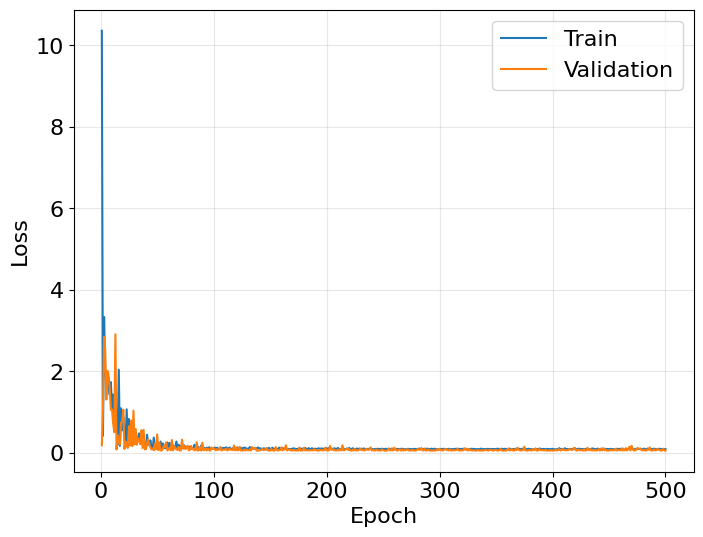

Final Train MSE (scaled): 0.094583
Final Test MSE (scaled): 0.060401
Final Test MSE (original scale): 0.060401


In [159]:
nn_rms_1 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_rms_1,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=RMSprop(eta=best_eta_rms_1),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_rms_1.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_rms_1.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

### Experiment 2: Two hidden layers & 100 hidden nodes

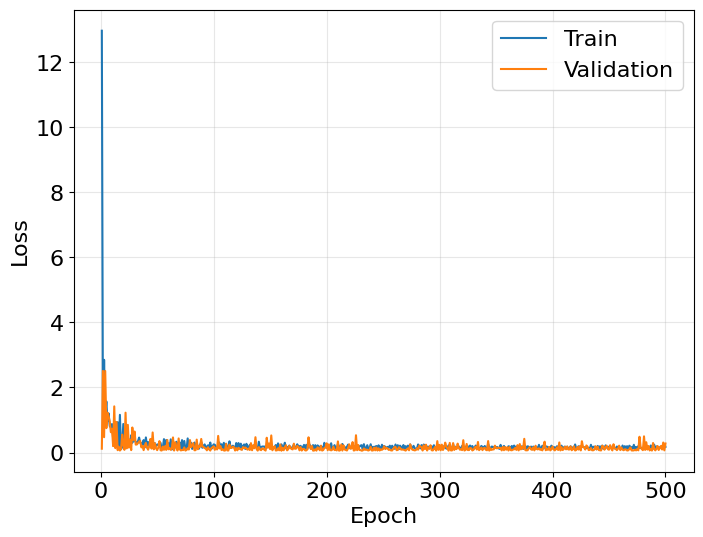

Final Train MSE (scaled): 0.175448
Final Test MSE (scaled): 0.277435
Final Test MSE (original scale): 0.277435


In [160]:
nn_rms_2 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_2,
    activations=activations_2,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_rms_2,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=RMSprop(eta=best_eta_rms_2),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_rms_2.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_rms_2.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

# Stochastic Gradient Descent with Adam

### Find best eta for Adam

In [161]:
best_eta_adam_1, best_mse_adam_1, results_adam_1 = find_best_eta(
    layer_sizes=layer_sizes_1,
    activations=activations_1,
    X_train=X_train_s,
    y_train=y_train_s,
    X_test=X_test_s,
    y_test=y_test_s,
    y_mean=y_mean,
    optimizer_type='adam',
    eta_vals=ETA_VALS,
    seed=SEED
)

best_eta_adam_2, best_mse_adam_2, results_adam_2 = find_best_eta(
    layer_sizes=layer_sizes_2,
    activations=activations_2,
    X_train=X_train_s,
    y_train=y_train_s,
    X_test=X_test_s,
    y_test=y_test_s,
    y_mean=y_mean,
    optimizer_type='adam',
    eta_vals=ETA_VALS,
    seed=SEED
)

print(f"Experiment 1: Best η: {best_eta_adam_1:.6f}, Best Test MSE: {best_mse_adam_1:.6f}")
print(f"Experiment 2: Best η: {best_eta_adam_2:.6f}, Best Test MSE: {best_mse_adam_2:.6f}")

  η=0.000010: Train MSE=0.181829, Test MSE=0.144075
  η=0.000100: Train MSE=0.168340, Test MSE=0.132326
  η=0.001000: Train MSE=0.100940, Test MSE=0.066655
  η=0.010000: Train MSE=0.095737, Test MSE=0.058286
  η=0.100000: Train MSE=0.094830, Test MSE=0.059353
  η=0.000010: Train MSE=0.179888, Test MSE=0.142501
  η=0.000100: Train MSE=0.112543, Test MSE=0.081175
  η=0.001000: Train MSE=0.095152, Test MSE=0.057628
  η=0.010000: Train MSE=0.094721, Test MSE=0.057177
  η=0.100000: Train MSE=0.101165, Test MSE=0.058459
Experiment 1: Best η: 0.010000, Best Test MSE: 0.058286
Experiment 2: Best η: 0.010000, Best Test MSE: 0.057177


### Experiment 1: One hidden layer & 50 hidden nodes

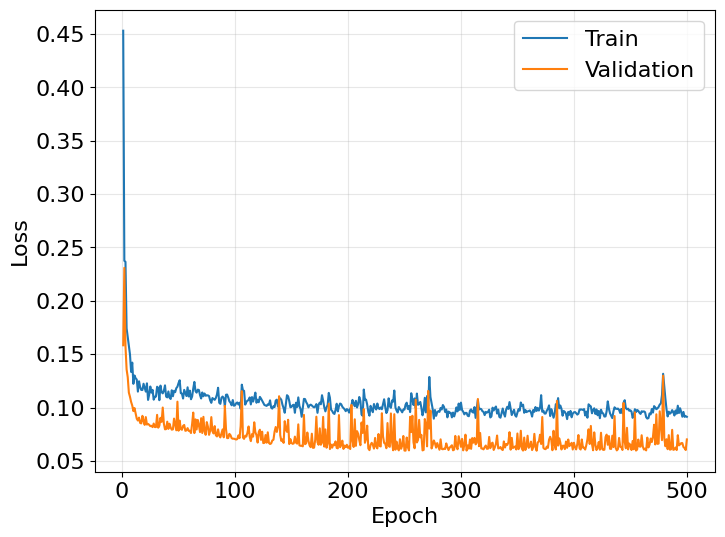

Final Train MSE (scaled): 0.091350
Final Test MSE (scaled): 0.070159
Final Test MSE (original scale): 0.070159


In [162]:
nn_adam_1 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_adam_1,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=Adam(eta=best_eta_adam_1),
            epochs=EPOCHS,
            batch_size=32,  
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_adam_1.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_adam_1.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

### Experiment 2: Two hidden layers & 100 hidden nodes

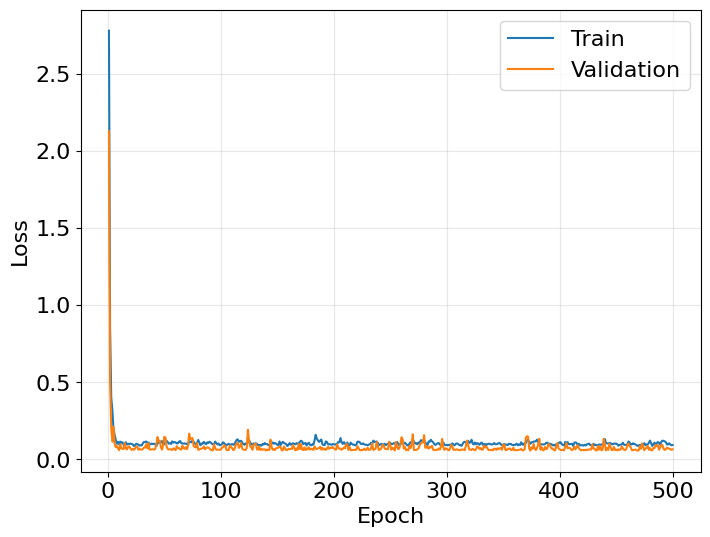

Final Train MSE (scaled): 0.093592
Final Test MSE (scaled): 0.065514
Final Test MSE (original scale): 0.065514


In [163]:
nn_adam_2 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_2,
    activations=activations_2,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_adam_2,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=Adam(eta=best_eta_adam_1),
            epochs=EPOCHS,
            batch_size=32,  
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_adam_2.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_adam_2.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

# Results for one hidden layer and 50 hidden nodes

In [164]:
print("\n" + "="*50)
print("ONE HIDDEN LAYER & 50 HIDDEN NODES")
print("="*50)
print(f"OLS (deg 14):      {ols_mse:.6f}")
print(f"NN + GD:           {best_mse_gd_1:.6f}  (eta={best_eta_gd_1:.4f})")
print(f"NN + RMSprop:      {best_mse_rms_1:.6f}  (eta={best_eta_rms_1:.4f})")
print(f"NN + Adam:         {best_mse_adam_1:.6f}  (eta={best_eta_adam_1:.4f})")
print("="*50)


ONE HIDDEN LAYER & 50 HIDDEN NODES
OLS (deg 14):      0.064547
NN + GD:           0.143966  (eta=0.0100)
NN + RMSprop:      0.057123  (eta=0.1000)
NN + Adam:         0.058286  (eta=0.0100)


# Results for two hidden layers and 100 hidden nodes each

In [165]:
print("\n" + "="*50)
print("TWO HIDDEN LAYERS & 100 HIDDEN NODES EACH")
print("="*50)
print(f"OLS (deg 14):      {ols_mse:.6f}")
print(f"NN + GD:           {best_mse_gd_2:.6f}  (eta={best_eta_gd_2:.4f})")
print(f"NN + RMSprop:      {best_mse_rms_2:.6f}  (eta={best_eta_rms_2:.4f})")
print(f"NN + Adam:         {best_mse_adam_2:.6f}  (eta={best_eta_adam_2:.4f})")
print("="*50)


TWO HIDDEN LAYERS & 100 HIDDEN NODES EACH
OLS (deg 14):      0.064547
NN + GD:           0.143622  (eta=0.0100)
NN + RMSprop:      0.056543  (eta=0.0100)
NN + Adam:         0.057177  (eta=0.0100)
